### '@author: Yulia Khlyaka'

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import numpy as dragon
import pandas as pd
import statsmodels.api as sm
import matplotlib

from pathlib import Path

import matplotlib.pyplot as plot
from pylab import rcParams

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
# Reading in the data
path = f'{Path().parent.absolute().parent}data/BTC-USD.csv'
df = pd.read_csv(path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008.0
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992.0
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000.0
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984.0
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008.0


In [3]:
cols = ['Open', 'Low', 'High', 'Volume', 'Adj Close']
df.drop(cols, axis=1, inplace=True)
df.head()

,Date,Close
0,2017-01-01,998.325012
1,2017-01-02,1021.750000
2,2017-01-03,1043.839966
3,2017-01-04,1154.729980
4,2017-01-05,1013.380005


In [4]:
# setting the Index to date
df_id = df.set_index('Date')
df_id = df_id.fillna(method='ffill')
df_id.sort_index(inplace=True)
df_id.index

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       ...
       '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04',
       '2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09'],
      dtype='object', name='Date', length=1501)

In [5]:
# Unix-time to 
df['Date'] = pd.to_datetime(df.Date)


# Resampling to daily frequency
df.index = df.Date
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

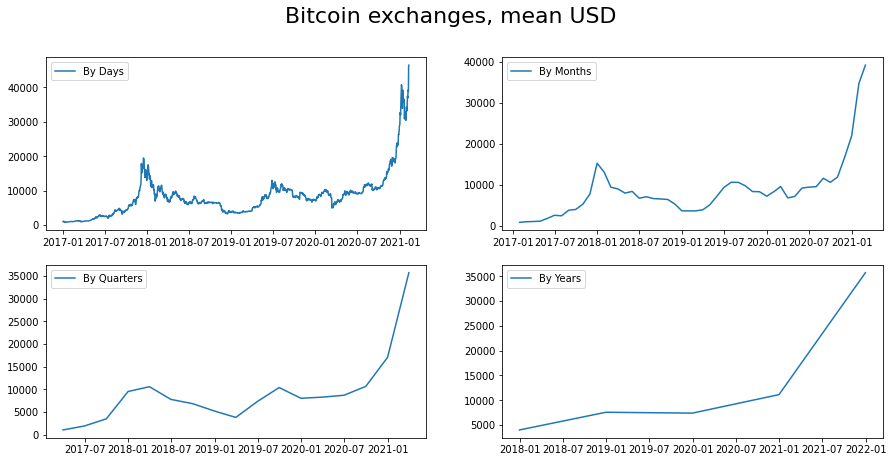

In [6]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Close, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Close, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=1.000000
The series are not stationary


<Figure size 1080x504 with 0 Axes>

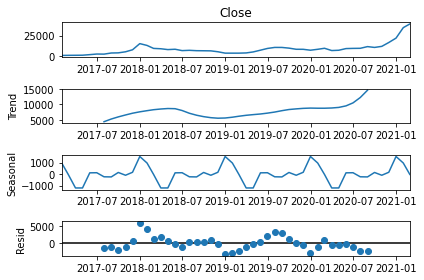

In [7]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
if sm.tsa.stattools.adfuller(df_month.Close)[1] > 0.05:
    print('The series are not stationary')
else:
    print('The series are stationary')
plt.show()

Search model the Stationarity  
1. p value > 0.05: Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary. 
2. p value < = 0.05: Rejects the Null Hypothesis (H0), the data is stationary. 

In [8]:
def search_stationarity(x):

    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()
    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='aquamarine',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    std = plot.plot(rolstd, color='teal', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
        

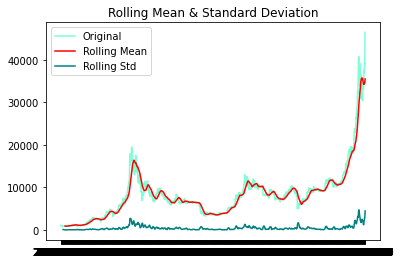

ADF Stastistic: 4.310172
p-value: 1.000000
The graph is non stationery
Critical values:
	1%: -3.435 
	5%: -2.864 
	10%: -2.568 


In [9]:
ts = df_id['Close']      
search_stationarity(ts)

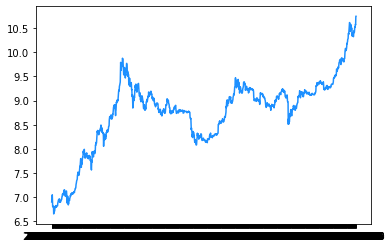

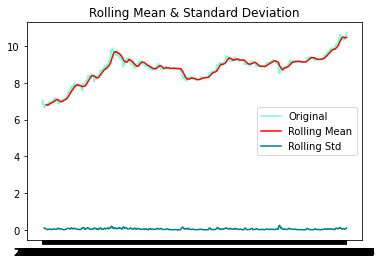

ADF Stastistic: -0.909454
p-value: 0.784843
The graph is non stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [10]:
# Log Transforming the series
ts_log = dragon.log(ts)
plot.plot(ts_log,color="dodgerblue")
plot.show()
search_stationarity(ts_log)

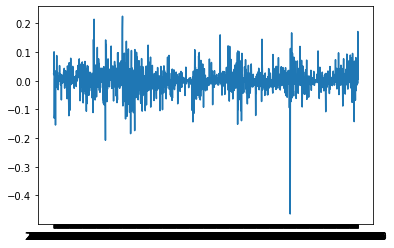

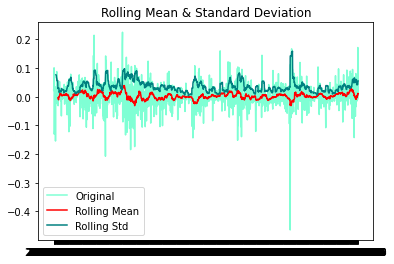

ADF Stastistic: -26.598929
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [11]:
# Remove trend and seasonality with differencing
ts_log_diff = ts_log - ts_log.shift()
plot.plot(ts_log_diff)
plot.show()
ts_log_diff.dropna(inplace=True)
search_stationarity(ts_log_diff)

In [12]:
'''Time series forecasting with SARIMAX'''
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal SARIMAX...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal SARIMAX...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [13]:
# Parameter selection for ARIMA using grid search
aic_best = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df, order=param, seasonal_order=param_seasonal, 
                                            enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            if aic_best == None:
                aic_best = results.aic
            else:
                if results.aic < aic_best:
                    aic_best = results.aic
                    best_mod = param, param_seasonal, results.aic
            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print('BEST SARIMAX: ', best_mod)

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:31910.731662783557
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:30690.832866787085
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:26599.25303025848
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:26388.78446684536
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:26544.312307773227
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:26529.477946573053
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:26404.569701004293
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:26352.272145670133
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:30799.145052328357
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:30301.718179924253
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:25155.925298748363
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:24965.260133551157
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:25145.149588241045
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:25103.58816113969
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:24997.130494403063
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:24966.513664270395
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:22872.586181320745
SARIMAX(0, 1, 0)x

In [14]:
# Converting the data to a logarithmic scale
bc_log = pd.DataFrame(np.log(df.Close))

# Splitting 80/20
index = round(len(df)*.80)
train = bc_log.iloc[:index]
test = bc_log.iloc[index:]

Interpretation der Restdiagramme im SARIMAX-Modell\

In [15]:
# Fitting the model to the training set (ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:22549.925201414422)
model = SARIMAX(train, 
                order=(0, 1, 1), 
                seasonal_order=(0,1,1,12),
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
outputs = model.fit()

In [16]:
print(outputs.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1201
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                1963.215
Date:                            Wed, 17 Feb 2021   AIC                          -3920.430
Time:                                    12:29:34   BIC                          -3905.226
Sample:                                01-01-2017   HQIC                         -3914.697
                                     - 04-15-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0267      0.020     -1.311      0.190      -0.067       0.013
ma.S.L12      -1.0003      0.799   

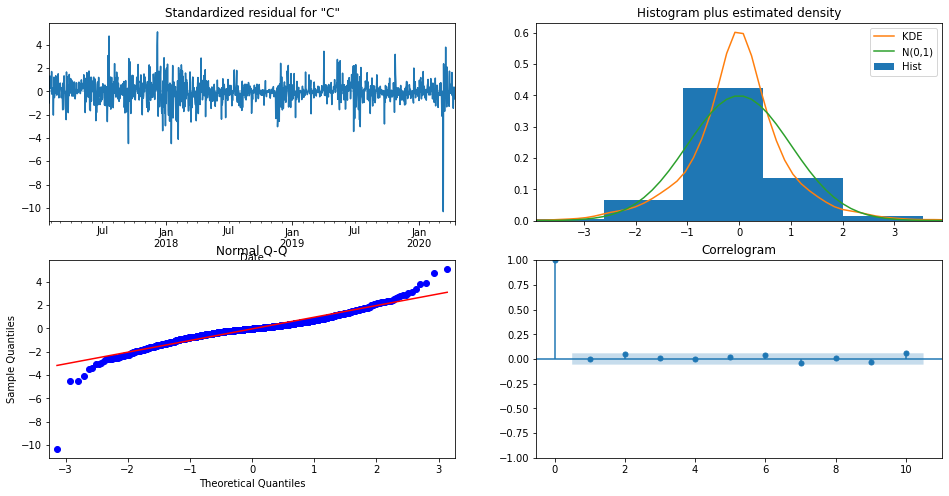

In [17]:
# Run Model Diagnostics

outputs.plot_diagnostics(figsize=(16, 8)) #always run model diagnostics to investigate any unusual behavior.
plt.show()

1. Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.\
2. Top Right: The density plot suggest normal distribution with mean zero.\
3. Bottom left: All the dots should fall perfectly in line with the red line.
Any significant deviations would imply the distribution is skewed.\
4. ACF plot shows the residual errors are not autocorrelated.\\

Overall, it to be a good fit.

In [18]:
size = int(len(ts_log)-100)
# Divide into train and test
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
#data_arima= ts_log
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. 
# We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    #model = ARIMA(history, order=(0, 1, 1))
    model = SARIMAX(history, order=(0, 1, 1), seasonal_order=(0,1,1,12))
    model_fit = model.fit(disp=-1)    
    output = model_fit.forecast()   
    pred_value = output[0]        
    original_value = test_arima[t]
    history.append(original_value)   
    pred_value = dragon.exp(pred_value)   
    original_value = dragon.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))

Printing Predicted vs Expected Values...


predicted = 13743.349416,   expected = 13550.489258,   error = 1.423271  %
predicted = 13566.093882,   expected = 13950.300781,   error = 2.754112  %
predicted = 13981.768190,   expected = 14133.707031,   error = 1.075011  %
predicted = 14114.124540,   expected = 15579.848633,   error = 9.407820  %
predicted = 15562.996834,   expected = 15565.880859,   error = 0.018528  %
predicted = 15492.663417,   expected = 14833.753906,   error = 4.441961  %
predicted = 14815.626974,   expected = 15479.567383,   error = 4.289141  %
predicted = 15540.287405,   expected = 15332.315430,   error = 1.356429  %
predicted = 15442.590862,   expected = 15290.902344,   error = 0.992018  %
predicted = 15349.420037,   expected = 15701.339844,   error = 2.241336  %
predicted = 15762.114574,   expected = 16276.343750,   error = 3.159365  %
predicted = 16335.877199,   expected = 16317.808594,   error = 0.110729  %
predicted = 16320.133881,   expected = 16068.138672,   er

/Users/yk/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 18111.195627,   expected = 18803.656250,   error = 3.682585  %
predicted = 18682.579676,   expected = 19142.382813,   error = 2.402016  %
predicted = 19099.332467,   expected = 19246.644531,   error = 0.765391  %
predicted = 19341.336913,   expected = 19417.076172,   error = 0.390065  %
predicted = 19533.809626,   expected = 21310.597656,   error = 8.337580  %
predicted = 21340.834845,   expected = 22805.162109,   error = 6.421034  %
predicted = 22882.751632,   expected = 23137.960938,   error = 1.102990  %
predicted = 23230.551544,   expected = 23869.832031,   error = 2.678194  %
predicted = 23825.278960,   expected = 23477.294922,   error = 1.482215  %
predicted = 23509.362152,   expected = 22803.082031,   error = 3.097301  %
predicted = 22905.261768,   expected = 23783.029297,   error = 3.690731  %
predicted = 23768.711732,   expected = 23241.345703,   error = 2.269086  %
predicted = 23321.920697,   expected = 23735.949219,   error = 1.744310  %
predicted = 23602.479488,

/Users/yk/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 33779.136656,   expected = 36824.363281,   error = 8.269597  %
predicted = 36715.100917,   expected = 39371.042969,   error = 6.745928  %
predicted = 39508.329733,   expected = 40797.609375,   error = 3.160184  %
predicted = 41057.739893,   expected = 40254.546875,   error = 1.995285  %
predicted = 40450.851586,   expected = 38356.441406,   error = 5.460387  %
predicted = 38616.905622,   expected = 35566.656250,   error = 8.576149  %
predicted = 35784.497873,   expected = 33922.960938,   error = 5.487543  %
predicted = 33915.654182,   expected = 37316.359375,   error = 9.113175  %
predicted = 37300.411118,   expected = 39187.328125,   error = 4.815120  %
predicted = 39313.482219,   expected = 36825.367188,   error = 6.756525  %
predicted = 36872.560969,   expected = 36178.140625,   error = 1.919447  %
predicted = 36318.000558,   expected = 35791.277344,   error = 1.471652  %
predicted = 35654.342421,   expected = 36630.074219,   error = 2.663745  %
predicted = 36599.105078,

/Users/yk/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 34125.092912,   expected = 34269.523438,   error = 0.421455  %
predicted = 34257.007954,   expected = 33114.359375,   error = 3.450614  %
predicted = 33310.126367,   expected = 33537.175781,   error = 0.677008  %
predicted = 33722.342892,   expected = 35510.289063,   error = 5.035009  %
predicted = 35631.467368,   expected = 37472.089844,   error = 4.911982  %
predicted = 37609.937270,   expected = 36926.066406,   error = 1.852000  %
predicted = 37095.011610,   expected = 38144.308594,   error = 2.750861  %
predicted = 38107.724787,   expected = 39266.011719,   error = 2.949846  %
predicted = 39314.823120,   expected = 38903.441406,   error = 1.057443  %
predicted = 39028.146296,   expected = 46196.464844,   error = 15.517028  %
predicted = 46036.371238,   expected = 46481.105469,   error = 0.956806  %



 Mean Error in Predicting Test Case Articles : 3.372116  %


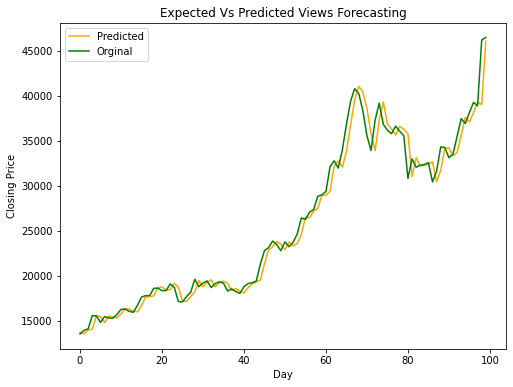

In [19]:
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plot.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plot.plot(test_day, predictions, color= 'orange')
plot.plot(test_day, originals, color = 'green')
plot.title('Expected Vs Predicted Views Forecasting')
plot.xlabel('Day')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()

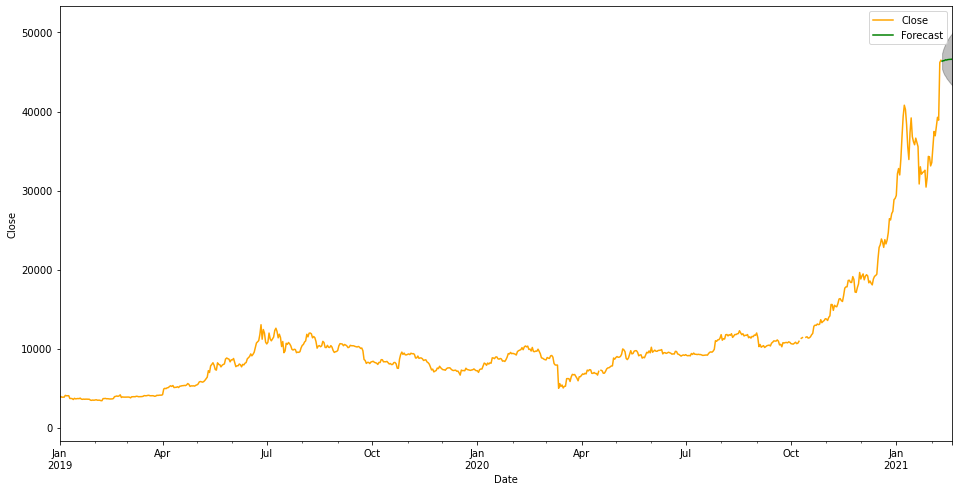

In [20]:
# Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=15)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='Observed', figsize=(16, 8), color='orange')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='green')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
ax.set_xlim(['2019-01-01','2021-02-19'])
plt.legend()
plt.show()